# Machine Learning Engineer Nanodegree

## This notebook is used to visualise components of solution and derive insights from them.

### Retreiving subset of the CelibA dataset

In the code cell below, we import the CelibA dataset (cropped and aligned) which has over 200,000 images of celebrities along with 40 different attributes for each image - Smiling being one of them - is the person in the image Smiling or not. We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `test_files` - numpy arrays containing file paths to images
- `test_targets` - numpy arrays containing onehot-encoded classification labels 

In [2]:
from glob import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import load_files       
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
IMG_H=218
IMG_W=178


# Data Augmentation is a key technique to increase variety in the input training set

I have used three parameters to randomly change the image 

- width shift by 20%
- height shift by 20%
- zoom in by by 20%
- horizontal flip

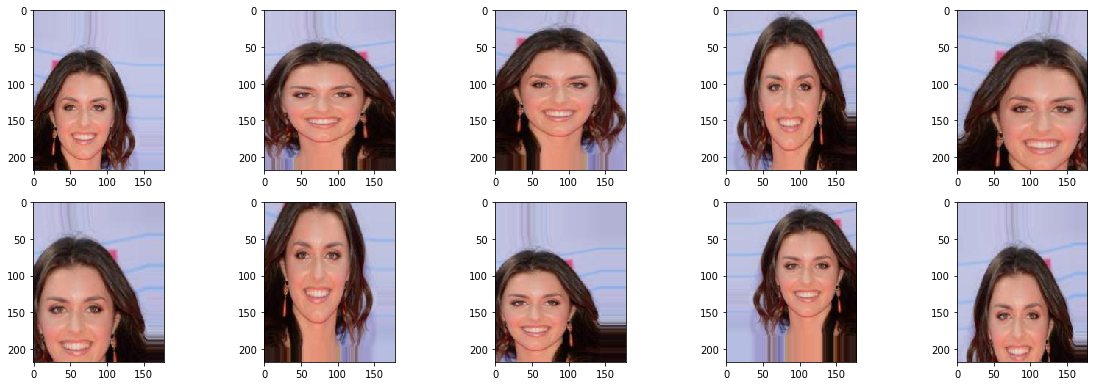

In [5]:
IMAGE_PATH='CelibA/img_align_celeba/000043.jpg'

datagen = ImageDataGenerator(
    #preprocessing_function = preprocess_input,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True)

img = load_img(IMAGE_PATH)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

i = 0
for batch in datagen.flow(x, batch_size=10,
                          save_to_dir='preview', save_prefix='aug', save_format='jpg'):
    i = i + 1
    if i > 9:
        break

aug_files = glob("preview/*.jpg")
plt.figure(figsize=(20,10))
columns = 5
for i, image_file in enumerate(aug_files):
    plt.subplot(len(aug_files) / columns + 1, columns, i + 1)
    img = load_img(image_file)
    plt.grid(False)
    plt.imshow(img)
    

# Predicting the result of CalibA test data set 
Instantiate and use the model.
Added all the functions from the main notebook to help prepare the testing data set.

In [217]:
from keras.models import load_model
model = load_model('input/saved_models/composite_model.hd5')

In [141]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(IMG_H, IMG_W))
    # convert PIL.Image.Image type to 3D tensor with shape (IMG_H, IMG_W, IMG_D)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return np.expand_dims(x, axis=0)
    
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [144]:
# define function to load train, test, and validation datasets
from sklearn.datasets import load_files  
from keras.utils import np_utils
def load_dataset(path):
    data = load_files(path, load_content=False)
    smile_files = np.array(data['filenames'])
    smile_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return smile_files, smile_targets


In [146]:
test_files, test_targets = load_dataset('input-3/dataset/test')

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

test_tensors = paths_to_tensor(test_files)


 48%|████▊     | 9551/19962 [00:32<00:51, 200.23it/s]


 89%|████████▉ | 17829/19962 [01:05<00:07, 284.61it/s]


100%|██████████| 19962/19962 [01:14<00:00, 268.91it/s]


In [105]:
# evaluate and print the test accuracy
# get index of predicted smile detection for each image in test set
smile_prediction = [np.argmax(model.predict(np.expand_dims(test_data, axis=0))) for test_data in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(smile_prediction)==np.argmax(test_targets, axis=1))/len(smile_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 90.4268%


# Predicting the result for real world images
Here, I have written functions that helped me to visualise the results and understand what featrues were leading to a positive identification of the smile

In [185]:
def predict_image(model, img, target, display = False):
    x = image.img_to_array(img)
    #x = cv2.resize(oriimg,(IMG_W,IMG_H))
    # convert 3D tensor to 4D tensor with shape (1, IMG_H, IMG_W, IMG_D) and return 4D tensor
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    pred = model.predict(x)
    
    if display:
        #print (pred)
        plt.imshow(img)    
        plt.show()   
        prediction = np.argmax(pred)
        if prediction == 0:
            predStr = "Not Smiling"
            predpc = pred[0][0] * 100
        else:
            predStr = "Smiling"
            predpc = pred[0][1] * 100
        if prediction == target:
            result = "Correct"
        else:
            result = "Incorrect"
        print ("\nPrediction: {} {:0.2f}% \nResult: {}".format( predStr, predpc, result))
        
    return np.argmax(pred[0])

In [186]:
def predict_image_from_file(model, img_path, target, display = False):
    img = image.load_img(img_path, target_size=(IMG_H, IMG_W))
    return predict_image(model, img, target, display)

In [223]:
from os import path
import time
# your code here    
loop = 0
match = 0
notmatch = 0

start = time.process_time()
for folder in range(0, 2):
    for file in range (0,15):
        filename="images/{}/{:05}.jpg".format(folder,file)
        if path.exists(filename):
            prediction = predict_image_from_file(model,filename, folder, False)
            if  prediction == folder:
                match = match + 1
            else:
                notmatch = notmatch + 1
            loop = loop + 1
            #print ("{},{}".format(filename, prediction))

print ("\n\nOverall Accuracy = {:0.2f}%".format( 100* match / loop))
print ( "Procesed {} images in {} seconds".format(loop, time.process_time() - start))



Overall Accuracy = 63.33%
Procesed 30 images in 37.0625 seconds


This is avery poor result for a model that performed very well against the CelebA data set. The failures were analysed and bucketized into three major groups.

- the face is not occupying good 
- there are more than one face in the picture
- the face is tilted to some side.

We will address the first two problems by using haarcascades to feed data into this model

# Improving the accuracy of the prediction 
In this function, I have tried to pre-process the image by passing it through a haarcascade. This extracts the first available face and presents it for the smile detector. In some sense, I have stiched multiple base models on top of each other.

Clearly, it yielded better result than the composite model alone when tried on real world images.

In [1]:
import cv2

# predict_smile
# first try to find a face using haarcascades, if found, then run smile_detection on only the face.
# if no face found by haarcascades, then feed it in directly to smile detector. Ideally, it should not detect

def predict_smile(model, filename, target = 1, display=False):
    # frontal face detection
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

    img = cv2.imread(filename)  

    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # assuming it will find a face if present.
    if len(faces) > 0 : 
        (x, y, w, h) =  faces[0] 
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)
        roi_color = img[y:y+h, x:x+w]

        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        cv_rgb = cv2.resize(cv_rgb, (IMG_W,IMG_H), interpolation = cv2.INTER_AREA)
        
    else:
        #face was not even found by haar - cascade. retain the original image
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv_rgb = cv2.resize(cv_rgb, (IMG_W,IMG_H), interpolation = cv2.INTER_AREA)
        
    return predict_image(model, cv_rgb, target, display)        

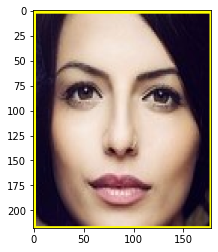


Prediction: Not Smiling 96.28% 
Result: Correct
images/0/00000.jpg,0


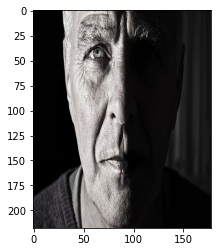


Prediction: Not Smiling 98.91% 
Result: Correct
images/0/00001.jpg,0


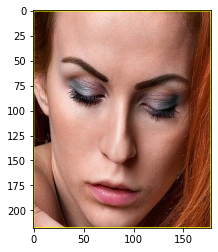


Prediction: Not Smiling 85.19% 
Result: Correct
images/0/00002.jpg,0


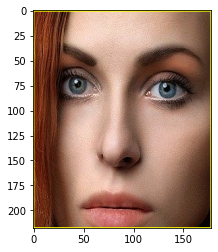


Prediction: Not Smiling 86.13% 
Result: Correct
images/0/00003.jpg,0


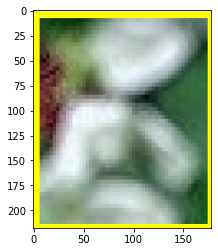


Prediction: Not Smiling 97.30% 
Result: Correct
images/0/00004.jpg,0


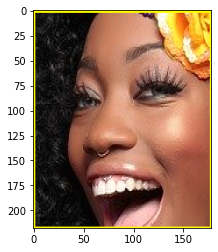


Prediction: Smiling 99.97% 
Result: Correct
images/1/00000.jpg,1


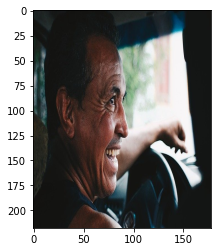


Prediction: Not Smiling 89.03% 
Result: Incorrect
images/1/00001.jpg,0


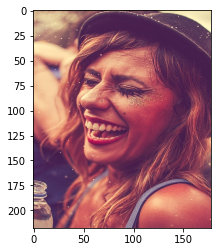


Prediction: Smiling 84.09% 
Result: Correct
images/1/00002.jpg,1


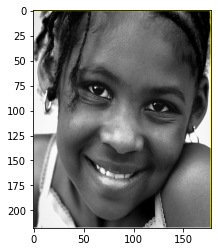


Prediction: Smiling 99.72% 
Result: Correct
images/1/00003.jpg,1


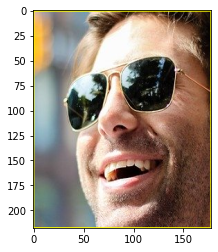


Prediction: Smiling 86.63% 
Result: Correct
images/1/00004.jpg,1


Overall Accuracy = 90.00%
Procesed 10 images in 17.859375 seconds


In [226]:
from os import path
import time
# your code here    
loop = 0
match = 0
notmatch = 0

start = time.process_time()
for folder in range(0, 2):
    for file in range (0,5):
        filename="images/{}/{:05}.jpg".format(folder,file)
        if path.exists(filename):
            prediction = predict_smile(model,filename, folder, True)
            if  prediction == folder:
                match = match + 1
            else:
                notmatch = notmatch + 1
            loop = loop + 1
            print ("{},{}".format(filename, prediction))

print ("\n\nOverall Accuracy = {:0.2f}%".format( 100* match / loop))
print ( "Procesed {} images in {} seconds".format(loop, time.process_time() - start))

Now that the pre-process step has helped, let us see how much accuracy is achieved over real world image set

In [224]:
from os import path
import time
# your code here    
loop = 0
match = 0
notmatch = 0

start = time.process_time()
for folder in range(0, 2):
    for file in range (0,15):
        filename="images/{}/{:05}.jpg".format(folder,file)
        if path.exists(filename):
            prediction = predict_smile(model,filename, folder, False)
            if  prediction == folder:
                match = match + 1
            else:
                notmatch = notmatch + 1
            loop = loop + 1
            #print ("{},{}".format(filename, prediction))

print ("\n\nOverall Accuracy = {:0.2f}%".format( 100* match / loop))
print ( "Procesed {} images in {} seconds".format(loop, time.process_time() - start))



Overall Accuracy = 90.00%
Procesed 30 images in 46.765625 seconds


Not bad. :-)